<img src="https://www.python.org/static/opengraph-icon-200x200.png" align="left" width="70" height="70"> <h1>Python Basics</h1>

[Python](https://www.python.org/) is an interpreted language originally designed for general-purpose programming, but it also became a fully-featured language for scentific computing thanks to its highly modularized and extensible design, and a growing scentific user/developer community. The first part of this tutorial is to show or remind you some basic syntax of Python.

In [82]:
print('hello world!')

hello world!


The real power of Python is the packages. There are many built-in ones, just like the one we will see below, and also many open-source packages developed by the Python community. There are several ways to import a package (module). For starters, you can import the module by its name:

In [83]:
import math
math.pi

3.141592653589793

Another common way to import is using a wildcard (namely `*`):

In [84]:
from math import *
pi

3.141592653589793

### Data types

Just like other languages, Python has several basic data types: `int`, `float`, `bool`, `str`, to define a variable of a certain type, one can simply write out the initial value:

In [85]:
i = 1
f = 3.1415
b = True or False
s = 'hello world!'

To create a list:

In [86]:
a = [0, 1, 2, 3, 4]
a

[0, 1, 2, 3, 4]

Notably the array in Python starts from 0. A list can be also generated by `range` function, minimally the only input is the **length** of the list. So to generate a list like above, we can write:

In [87]:
a = range(5)
a

range(0, 5)

Note that in Python 3K, this will generate an iterator (a [Range](https://docs.python.org/3/library/stdtypes.html#typesseq-range) class to be precise). Following code will convert it to a `list` instance:

In [88]:
a = list(range(5))
a

[0, 1, 2, 3, 4]

*Optionally*, the most robust and universal way to convert a iterable object to a list is through [list comprehension](https://docs.python.org/3/tutorial/datastructures.html#list-comprehensions):

In [89]:
a = [_ for _ in range(5)]
a

[0, 1, 2, 3, 4]

### Control flow

The list comprehension mentioned above is essentially an one liner of a `for` loop. The full version of the `for` loop looks like the following:

In [90]:
for i in range(5):
    print(i)

0
1
2
3
4


Which iterates through numbers from 0 to 4. `if` block is used for making choices. Let's first initialize two integers:

In [91]:
a = 3; b = -3

Then write out a control block as follows:

In [92]:
if a > b:
    print('a is bigger than b')
elif a < b:
    print('a is smaller than b')
else:
    print('a equals to b')

a is bigger than b


### Numpy

[Numpy](http://www.numpy.org/) is a Python package for numerical computing and linear algebra. It is also a required installation for ProDy.

In [93]:
from numpy import *

The most fundamental data type in numpy is `ndarray` (n-dimensional array). It can be used to represent vectors or matrices. There are various ways to initialize an vector in numpy:

In [94]:
v = arange(10, dtype=float)
v

array([0., 1., 2., 3., 4., 5., 6., 7., 8., 9.])

In [95]:
v = zeros(5)
v

array([0., 0., 0., 0., 0.])

In [96]:
v.shape

(5,)

Or a matrix:

In [97]:
V = zeros([5, 5])
V

array([[0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0.]])

In [98]:
V.shape

(5, 5)

In [99]:
V = ones([5, 5])
V

array([[1., 1., 1., 1., 1.],
       [1., 1., 1., 1., 1.],
       [1., 1., 1., 1., 1.],
       [1., 1., 1., 1., 1.],
       [1., 1., 1., 1., 1.]])

In [100]:
I = eye(5)
I

array([[1., 0., 0., 0., 0.],
       [0., 1., 0., 0., 0.],
       [0., 0., 1., 0., 0.],
       [0., 0., 0., 1., 0.],
       [0., 0., 0., 0., 1.]])

### Matplotlib

[Matplotlib](https://matplotlib.org/) is a package used by ProDy to visualize the data. It is compatible with Python objects as well as numpy objects and provides [MATLAB](https://www.mathworks.com/products/matlab.html)-like syntax for plotting data points, matrices, 3D coordinates, etc.

In [101]:
from matplotlib.pyplot import *

In [102]:
x = arange(0, 2*pi, 0.1)
y = sin(x)
y

array([ 0.        ,  0.09983342,  0.19866933,  0.29552021,  0.38941834,
        0.47942554,  0.56464247,  0.64421769,  0.71735609,  0.78332691,
        0.84147098,  0.89120736,  0.93203909,  0.96355819,  0.98544973,
        0.99749499,  0.9995736 ,  0.99166481,  0.97384763,  0.94630009,
        0.90929743,  0.86320937,  0.8084964 ,  0.74570521,  0.67546318,
        0.59847214,  0.51550137,  0.42737988,  0.33498815,  0.23924933,
        0.14112001,  0.04158066, -0.05837414, -0.15774569, -0.2555411 ,
       -0.35078323, -0.44252044, -0.52983614, -0.61185789, -0.68776616,
       -0.7568025 , -0.81827711, -0.87157577, -0.91616594, -0.95160207,
       -0.97753012, -0.993691  , -0.99992326, -0.99616461, -0.98245261,
       -0.95892427, -0.92581468, -0.88345466, -0.83226744, -0.77276449,
       -0.70554033, -0.63126664, -0.55068554, -0.46460218, -0.37387666,
       -0.2794155 , -0.1821625 , -0.0830894 ])

Text(0.5,1,'sin')

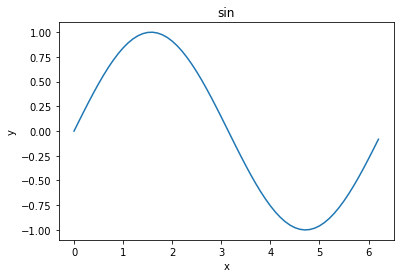

In [103]:
plot(x, y)
xlabel('x')
ylabel('y')
title('sin')

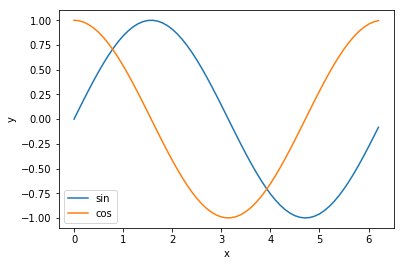

In [104]:
y2 = cos(x)
plot(x, y, x, y2)
xlabel('x')
ylabel('y')
legend(['sin', 'cos'])

<img src="http://prody.csb.pitt.edu/_static/ubiquitin.png" align="left" width="55" height="55"> <h1>Prody Basics</h1>

This tutorial aims to teach basic data structures and functions in Prody. First we need to import required packages:

In [105]:
from prody import *
from pylab import *
%matplotlib inline
confProDy(auto_secondary=True)

@> ProDy is configured: auto_secondary=True


These import commands will load numpy, matplotlib, and ProDy into the memory. `confProDy` is used to modify the default behaviors of ProDy. Here we turned off `auto_show` so that the plots can be made in the same figure, and we turn on `auto_secondary` to parse the secondary structure information whenever we load a PDB into ProDy. See [here](http://prody.csb.pitt.edu/manual/reference/prody.html?highlight=confprody#prody.confProDy) for a complete list of behaviors that can be changed by this function. This function only needs to be called once, and the setting will be remembered by ProDy.

### Load PDB files and visualization

ProDy comes with many functions that can be used to fetch data from [Protein Data Bank](https://www.rcsb.org/). Let's first parse a structure:

In [106]:
p38 = parsePDB('1p38')
p38

@> PDB file is found in working directory (1p38.pdb.gz).
@> 2962 atoms and 1 coordinate set(s) were parsed in 0.02s.
@> Secondary structures were assigned to 188 residues.


<AtomGroup: 1p38 (2962 atoms)>

`parsePDB` will download the PDB file and load it into the memory. Let's inspect the variable `p38`:

In [107]:
p38

<AtomGroup: 1p38 (2962 atoms)>

To visualize the structure:

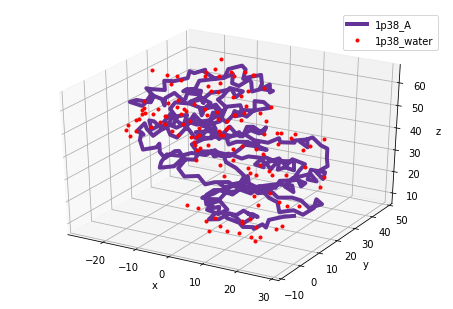

In [108]:
showProtein(p38);
legend();

If you would like to display the 3D structure using other packages or your own code, you can get the 3D coordinates via:

In [109]:
p38.getCoords()

array([[ 28.492,   3.212,  23.465],
       [ 27.552,   4.354,  23.629],
       [ 26.545,   4.432,  22.489],
       ...,
       [ 18.872,   8.33 ,  36.716],
       [-22.062,  21.632,  42.029],
       [  1.323,  30.027,  65.103]])

In [110]:
p38.getCoords().shape

(2962, 3)

@> Kirchhoff was built in 0.01s.


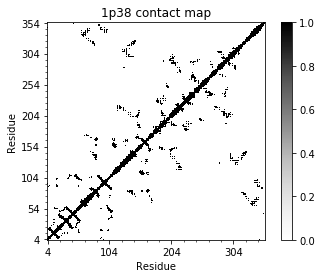

In [111]:
showContactMap(p38.ca, cmap='Greys');

`AtomGroup` is essentially a collection of protein atoms. Each atom can be indexed/queried/found by the following way:

In [112]:
p38[10]

<Atom: CA from 1p38 (index 10)>

This will give you the **11-th** atom from `p38`, noting that Python index starts from **0**. We can also find the residues, as opposed to atoms, by using **residue numbers**:

In [113]:
p38[10].getResnum()

5

In [114]:
p38[10].getCoords()

array([24.179,  4.807, 21.907])

@> ProDy is configured: auto_show=False


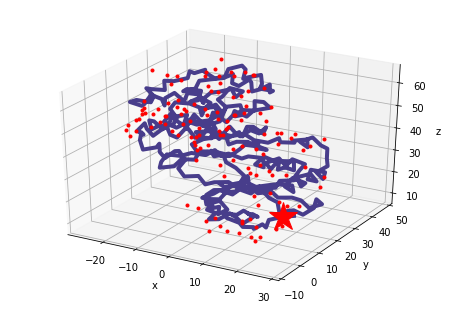

In [115]:
confProDy(auto_show=False)
showProtein(p38);
ax3d = gca()
x, y, z = p38[10].getCoords()
ax3d.plot([x], [y], [z], 'r*', markersize=30);

We could select a chain, e.g. chain A, of the protein by indexing using its identifier, like the following:

In [116]:
p38['A']

<Chain: A from 1p38 (480 residues, 2962 atoms)>

In [117]:
p38['A'].getSequence()

'ERPTFYRQELNKTIWEVPERYQNLSPVGSGAYGSVCAAFDTKTGHRVAVKKLSRPFQSIIHAKRTYRELRLLKHMKHENVIGLLDVFTPARSLEEFNDVYLVTHLMGADLNNIVKCQKLTDDHVQFLIYQILRGLKYIHSADIIHRDLKPSNLAVNEDCELKILDFGLARHTDDEMTGYVATRWYRAPEIMLNWMHYNQTVDIWSVGCIMAELLTGRTLFPGTDHIDQLKLILRLVGTPGAELLKKISSESARNYIQSLAQMPKMNFANVFIGANPLAVDLLEKMLVLDSDKRITAAQALAHAYFAQYHDPDDEPVADPYDQSFESRDLLIDEWKSLTYDEVISFVPPPLD'

We could also provide a **[residue number](https://pdb101.rcsb.org/learn/guide-to-understanding-pdb-data/primary-sequences-and-the-pdb-format)** in addition to find the exact residue:

In [118]:
p38['A', 10]

<Residue: ARG 10 from Chain A from 1p38 (11 atoms)>

This will give you the residue with the residue number of 10, which is an arginine in `p38`. Please note the difference between this line and the previous one. 

In [119]:
p38['A', 10].getNames()

array(['N', 'CA', 'C', 'O', 'CB', 'CG', 'CD', 'NE', 'CZ', 'NH1', 'NH2'],
      dtype='<U6')

Note that some ProDy objects may not support indexing using a chain identifier or a residue number. In such cases, we can first obtain a hierarchical view of the object:

In [160]:
hv = p38.getHierView()

And then use `HierView` to index using a chain identifier and residue number as it will always be supported:

In [161]:
hv['A', 10]

<Residue: ARG 10 from Chain A from 1p38 (11 atoms)>

### Retrive data from AtomGroup

Many properties of the protein can be acquired by functions named like "getxxx". For instance, we could obtain the secondary structure as an array:

In [122]:
p38.getSecstrs()

array(['C', 'C', 'C', ..., '', '', ''], dtype='<U1')

In this way, we can obtain the secondary structure information for every single atom.

In [162]:
len(p38.getSecstrs())

2962

However, sometimes we only care about alpha-carbons,

In [163]:
p38.ca

<Selection: 'ca' from 1p38 (351 atoms)>

In [164]:
len(p38.ca.getSecstrs())

351

In many cases it is more convenient to play with such information as a string. As an example, we could convert the above array into a string concisely using the python built-in `join` function:

In [123]:
''.join(p38.ca.getSecstrs())

'CCCCEEEEEECCEEEEEECCCCCCEEEECCCCEEEEEEECCCCCCEEEEEEECCCCCCHHHHHHHHHHHHHHHHCCCCCCCCCCEEECCCCCCCCCCCCEEEEECCCCCHHHHHHHCCCCHHHHHHHHHHHHHHHHHHHHHCCCCCCCCGGGEEECCCCCEEECCCCCCCCCCCCCCCCCHHHHHCCHHHHCCCCCCCGGGGGGGGGGGGGGGGGCCCCCCCCCHHHHHHHHHHHHCCCCHHHHHHCCCHHHHHHHHHCCCCCCCCGGGCCCCCCHHHHHHHHHHCCCCGGGCCCHHHHHCCGGGCCCCCGGGCCCCCCCCCGGGGCCCCHHHHHHHHHHHHHCCCCCCCC'

**C** is for coil, **H** for alpha helix, **I** for pi helix, **G** for 3-10 helix, and **E** for beta strand (sheet).

[Debye–Waller factor](https://en.wikipedia.org/wiki/Debye%E2%80%93Waller_factor), commonly known as the B-factor, indicates the uncertainty of an atom due to thermal fluctuations. In ProDy we could access such information, if stored in the PDB, by:

In [124]:
betas = p38.ca.getBetas()
betas.shape

(351,)

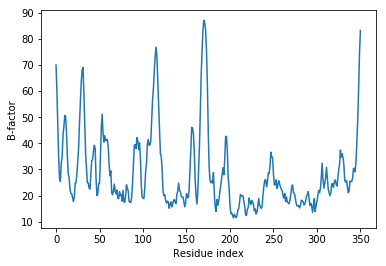

In [125]:
plot(betas);
ylabel('B-factor');
xlabel('Residue index');

If we would like to use residue numbers in the PDB, instead of the indices, as the x-axis of the plot, it would be much more convenient to use the ProDy plotting function, `showAtomicLines`.

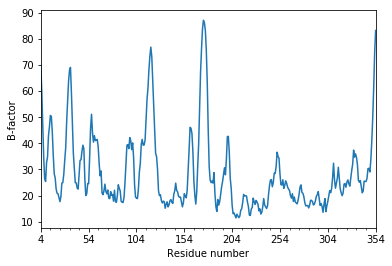

In [126]:
showAtomicLines(betas, atoms=p38.ca);
ylabel('B-factor');
xlabel('Residue number');

To get a complete list of "get" function, you can type `p38.get<TAB>`.

In [measure](http://prody.csb.pitt.edu/manual/reference/measure/index.html?highlight=measure#module-prody.measure) module, you can find various functions for calculations for structural properties. For example, you can calculate the phi angle of 11th residue:

In [127]:
calcPhi(p38['A', 10])

-115.5351427673999

In [128]:
round(calcPhi(p38['A', 10]), 3)

-115.535

A [dihedral angle](https://en.wikipedia.org/wiki/Dihedral_angle) is the angle between two intersecting planes. In chemistry it is the angle between planes through two sets of three atoms, having two atoms in common. In proteins, there are two most interested dihedral angles, namely Phi and Psi, and they are illustrated as follows.
<img src="https://pitt.box.com/shared/static/taq12ir6r4s7rskfyycm9t2zjva0eawi.png" width="400" height="400">
<img src="https://pitt.box.com/shared/static/q23s5crz0svu8yu2v0br7gab2fa7y3o0.png" width="400" height="400">

Note that the residue at N-terminus or C-terminus does not have a Phi or Psi angle, respectively. If we calculate the Phi and Psi angle for every non-terminal residue, we can obtain a [Ramachandran plot](https://en.wikipedia.org/wiki/Ramachandran_plot) for a protein. An example of Ramachandran plot for human [PCNA](https://en.wikipedia.org/wiki/Proliferating_cell_nuclear_antigen) is shown as follows:
<img src="https://upload.wikimedia.org/wikipedia/commons/4/43/1axc_PCNA_ProCheck_Rama.jpg" align="bottom" width="300" height="300">

Three favored regions (in red)--upper left: beta sheet; center left: alpha helix; center right: left-handed helix. Each blue data point corresponds to the two dihedrals of a residue. We will reproduce this plot for ubiquitin (we will only reproduce the points).

In [129]:
chain = p38['A']
Phi = []; Psi = []; c = []
for res in chain.iterResidues():
    try:
        phi = calcPhi(res)
        psi = calcPsi(res)
    except:
        continue
    else:
        Phi.append(phi)
        Psi.append(psi)
        if res.getResname() == 'GLY':
            c.append('r')
        else:
            c.append('b')

In the above code, we use an exception handler to exclude the terminal residues from the calculation.

Text(0,0.5,'Psi (degree)')

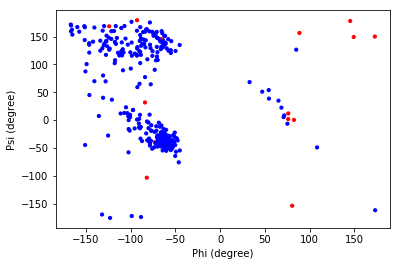

In [130]:
scatter(Phi, Psi, c=c, s=10);
xlabel('Phi (degree)');
ylabel('Psi (degree)');

### Selection

In theory you could retrieve any set of atoms by indexing the `AtomGroup`, but it would be cumbersome to do so. To make it more convienient, ProDy provides VMD-like syntax for selecting atoms. Here lists a few common selection strings, and for a more complete tutorial on selection, please see [here](http://prody.csb.pitt.edu/tutorials/prody_tutorial/selection.html).

In [131]:
ca = p38.select('calpha')
ca

<Selection: 'calpha' from 1p38 (351 atoms)>

In [132]:
p38.ca

<Selection: 'ca' from 1p38 (351 atoms)>

In [133]:
bb = p38.select('backbone')
p38.bb

<Selection: 'bb' from 1p38 (1404 atoms)>

We could also perform some simple selections right when the structure is being parsed. For example, we can specify that we would like to obtain only alpha-carbons of chain A of the p38 as follows:

In [155]:
chainA_ca = parsePDB('1p38', chain='A', subset='ca')

@> PDB file is found in working directory (1p38.pdb.gz).
@> 351 atoms and 1 coordinate set(s) were parsed in 0.01s.
@> Secondary structures were assigned to 188 residues.


We could find the chain A using selection (as an alternative to the indexing method shown above):

In [156]:
chA = p38.select('calpha and chain A')
chA

<Selection: 'calpha and chain A' from 1p38 (351 atoms)>

Selection also works for finding a single residue or multiple residues:

In [136]:
res = p38.ca.select('chain A and resnum 10')
res.getResnums()

array([10])

In [137]:
res = p38.ca.select('chain A and resnum 10 11 12')
res.getResnums()

array([10, 11, 12])

In [138]:
head = p38.ca.select('resnum < 50')
head.numAtoms()

46

We can also select a range of residues by:

In [139]:
fragment = p38.ca.select('resnum 50 to 100')

If we have data associated to the full length of the protein, we can slice the data using the `sliceAtomicData`:

In [167]:
subbetas = sliceAtomicData(betas, atoms=p38.ca, select=fragment)

We can visualize the data of this range using `showAtomicLines`:

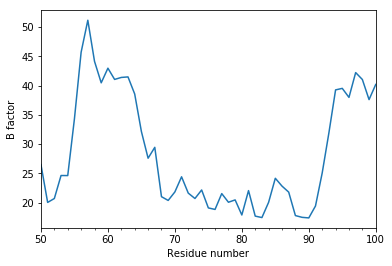

In [168]:
showAtomicLines(subbetas, atoms=fragment);
xlabel('Residue number');
ylabel('B factor');

Or highlight the subset in the plot of the whole protein:

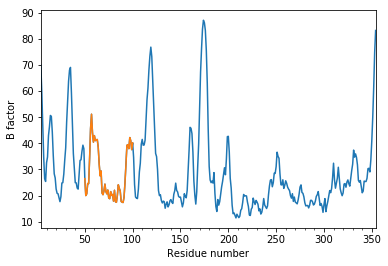

In [169]:
showAtomicLines(betas, atoms=p38.ca, overlay=True);
showAtomicLines(subbetas, atoms=fragment, overlay=True);
xlabel('Residue number');
ylabel('B factor');

Selection also allows us to extract particular amino acid types:

In [170]:
args = p38.ca.select('resname ARG')
args

<Selection: '(resname ARG) and (ca)' from 1p38 (19 atoms)>

Again, combined with `sliceAtomicData` and `showAtomicLines`, we can highlight these residues in the plot of the whole protein:

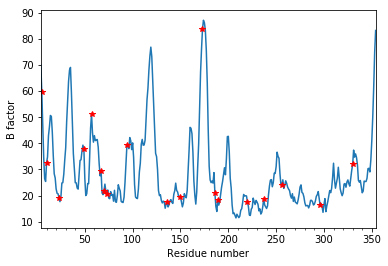

In [171]:
argbetas = sliceAtomicData(betas, atoms=p38.ca, select=args)
showAtomicLines(betas, atoms=p38.ca, overlay=True);
showAtomicLines(argbetas, atoms=args, linespec='r*', overlay=True);
xlabel('Residue number');
ylabel('B factor');

### Compare and align structures

You can also compare different structures using some of the methods in proteins module. Let’s parse another p38 MAP kinase structure. 

In [147]:
bound = parsePDB('1zz2')

@> PDB file is found in working directory (1zz2.pdb.gz).
@> 2872 atoms and 1 coordinate set(s) were parsed in 0.02s.
@> Secondary structures were assigned to 220 residues.


You can find similar chains in structure 1p38 and 1zz2 using `matchChains` function

In [148]:
results = matchChains(p38, bound)
results[0]

@> Checking AtomGroup 1p38: 1 chains are identified
@> Checking AtomGroup 1zz2: 1 chains are identified
@> Trying to match chains based on residue numbers and names:
@>   Comparing Chain A from 1p38 (len=351) and Chain A from 1zz2 (len=337):
@> 	Match: 337 residues match with 99% sequence identity and 96% overlap.


(<AtomMap: Chain A from 1p38 -> Chain A from 1zz2 from 1p38 (337 atoms)>,
 <AtomMap: Chain A from 1zz2 -> Chain A from 1p38 from 1zz2 (337 atoms)>,
 99.40652818991099,
 96.01139601139602)

In Python, a tuple (or any indexable objects) can be unpacked by:

In [149]:
apo_chA, bnd_chA, seqid, overlap = results[0]
apo_chA

<AtomMap: Chain A from 1p38 -> Chain A from 1zz2 from 1p38 (337 atoms)>

In [150]:
bnd_chA

<AtomMap: Chain A from 1zz2 -> Chain A from 1p38 from 1zz2 (337 atoms)>

The first two terms are the mapping of the proteins to each other. Then the third term is the sequence identity:

In [172]:
seqid

99.40652818991099

and the forth term is the sequence coverage:

In [152]:
overlap

96.01139601139602

If we calculate RMSD right now, we will obtain the value for the unsuperposed proteins:

In [75]:
calcRMSD(bnd_chA, apo_chA)

72.93023086946586

After superposition, the RMSD will be much improved,

In [174]:
bnd_chA, transformation = superpose(bnd_chA, apo_chA)
calcRMSD(bnd_chA, apo_chA)

1.862801490869549

@> ProDy is configured: auto_show=False


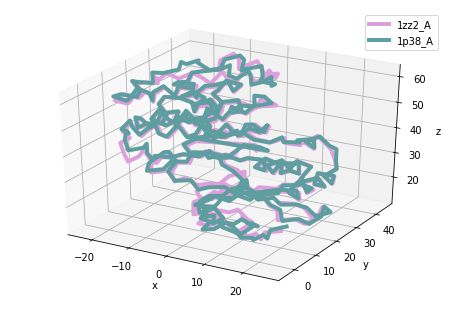

In [175]:
confProDy(auto_show=False)
showProtein(bnd_chA);
showProtein(apo_chA);
legend();

To visualize the superposition of the full proteins, we need to apply transform matrix to the entire structure:

In [176]:
transformation.apply(bound)

<AtomGroup: 1zz2 (2872 atoms)>

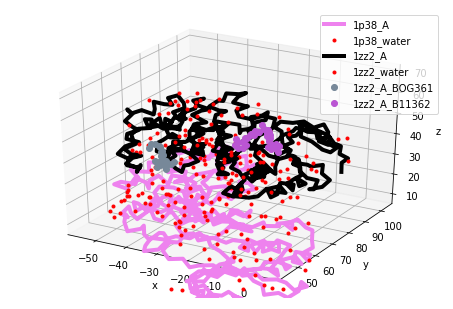

In [177]:
showProtein(p38);
showProtein(bound);
legend();

# Advanced Visualization

Using `matplotlib`, we only obtained a very simple linear representation of proteins. ProDy also support a more sophisticated way of visualizing proteins in 3D via [py3Dmol](http://3dmol.csb.pitt.edu/):

In [8]:
import py3Dmol
showProtein(p38);

You appear to be running in JupyterLab. You need to install the 3dmol extension: 
 jupyter labextension install jupyterlab_3dmol

The limitation is that `py3Dmol` only works in an iPython notebook. You can always write out the protein to a PDB file and visualize it in an external program:

In [93]:
writePDB('bound_aligned.pdb', bnd_chA)

'bound_aligned.pdb'